In [ ]:
# google drive link
!gdown 'https://drive.google.com/u/1/uc?id=1Kspfhle9vIqG9xR1Wf-ltE_qm06SOirJ&export=download'
!gdown 'https://drive.google.com/u/1/uc?id=1KcpuMeLZruwTKVp0ix9IIqIny6m-ih6l&export=download'
!gdown 'https://drive.google.com/u/1/uc?id=1KxmyhqaHIDFMVxWpO9a_KmzwLt0orNoD&export=download'

Downloading...
From: https://drive.google.com/u/1/uc?id=1Kspfhle9vIqG9xR1Wf-ltE_qm06SOirJ&export=download
To: /content/sample_hbb.csv
100% 56.7M/56.7M [00:01<00:00, 54.5MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=1KcpuMeLZruwTKVp0ix9IIqIny6m-ih6l&export=download
To: /content/sample_q.csv
100% 48.5M/48.5M [00:00<00:00, 144MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=1KxmyhqaHIDFMVxWpO9a_KmzwLt0orNoD&export=download
To: /content/sample_test.csv
100% 52.6M/52.6M [00:00<00:00, 162MB/s]


In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import matplotlib.pyplot as plt

In [ ]:
def load_samples(filename):
    print('load from', filename)
    fin = open(filename)
    lines = fin.readlines()
    idx_cur, samples, evt = -1, [], []
    for l in lines[1:]:
        idx, code, px, py, pz = l.split(',')
        if idx_cur != int(idx):
            idx_cur = int(idx)
            if len(evt) > 0:
                samples.append(evt)
                evt = []
        else:
            evt.append([int(code), float(px), float(py), float(pz)])
    samples.append(evt)
    print(len(samples), 'events loaded.')
    return samples


def prepare_features(samples):
    features = []
    charge = [0, -1 ,+1 ,-1 ,+1 ,-1 ,+1 ,0]
    for evt in samples:
        nr_feat = 6
        feat = np.zeros(8*nr_feat + 2)
        px = py = pz = totE = 0.
        for p in evt:
            code = p[0]
            px += p[1]
            py += p[2]
            pz += p[3]
            E = (p[1]**2+p[2]**2+p[3]**2)**0.5
            totE += E
            feat[p[0] *nr_feat : (p[0]+1) *nr_feat] += np.array([1, charge[p[0]], p[1], p[2], p[3], E])
        M = (totE**2 - (px**2+py**2+pz**2))**0.5
        feat[-1] = M
        feat[-2] = totE
        features.append(feat)
        # for p in evt:
        # features.append([len(evt)/100., M/100.])
    return features


def normalize(x_train, x_test):
  scale = np.mean(x_train, axis=0)
  scale[scale == 0] = 1
  x_train = x_train/scale
  x_test = x_test/scale

  return x_train, x_test

In [ ]:
def train_valid_split(X, y, valid_ratio, seed):
    np.random.seed(seed)
    '''Split provided training data into training set and validation set'''
    if valid_ratio != 0:
      val_size = int(valid_ratio * len(X)) 
      train_set_size = len(X) - val_size
      idx = np.random.permutation(len(X))
      x_train = X[idx[val_size:]]
      x_val = X[idx[:val_size]]
      y_train = y[idx[val_size:]]
      y_val = y[idx[:val_size]]
      return x_train, y_train, x_val, y_val
    
    return X, y, np.zeros(1), np.zeros(1)

In [ ]:
sample_sig = load_samples('./sample_hbb.csv')
sample_bkg = load_samples('./sample_q.csv')
sample_test = load_samples('./sample_test.csv')

load from ./sample_hbb.csv
40000 events loaded.
load from ./sample_q.csv
40000 events loaded.
load from ./sample_test.csv
40000 events loaded.


In [ ]:
x_train_org = np.array(prepare_features(sample_sig)+prepare_features(sample_bkg))
y_train_org = np.array([1]*len(sample_sig)+[0]*len(sample_bkg))
x_test_org = np.array(prepare_features(sample_test))

In [26]:
config = {'seed':1126,
      'valid_ratio': 0.}

In [27]:
y_train = y_train_org
X_train, X_test = normalize(x_train_org, x_test_org)
X_train, y_train, X_valid, y_valid = train_valid_split(X_train, y_train, config['valid_ratio'], config['seed'])
# Print out the data size.
print(f"""train_data size: {X_train.shape}
valid_data size: {X_valid.shape}
test_data size: {X_test.shape}
{y_train.shape}""")

train_data size: (80000, 50)
valid_data size: (1,)
test_data size: (40000, 50)
(80000,)


In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 建立 XGBClassifier 模型
xgboostModel = XGBClassifier(n_estimators=100, max_depth=20, learning_rate= 0.05, verbosity=1, eval_metric=accuracy_score)
# 使用訓練資料訓練模型
xgboostModel.fit(X_train, y_train)
print('訓練集: ',xgboostModel.score(X_train,y_train))
# print('測試集: ',xgboostModel.score(X_valid,y_valid))

訓練集:  0.9868625


In [29]:
y_pred = xgboostModel.predict(X_test)

In [30]:
fout = open('xgb_predicts.csv', 'w')
fout.write("id,class\n")
for idx, p in enumerate(y_pred):
    fout.write('%d,%d\n' % (idx, p > 0.5))
fout.close()

In [ ]:
feat_name = []
code = ['n', 'charge', 'px', 'py', 'pz', 'E']
for i in range(8):
    for j in range(6):
        feat_name.append(f'{i} {code[j]}')
feat_name.append('totE')
feat_name.append('M')

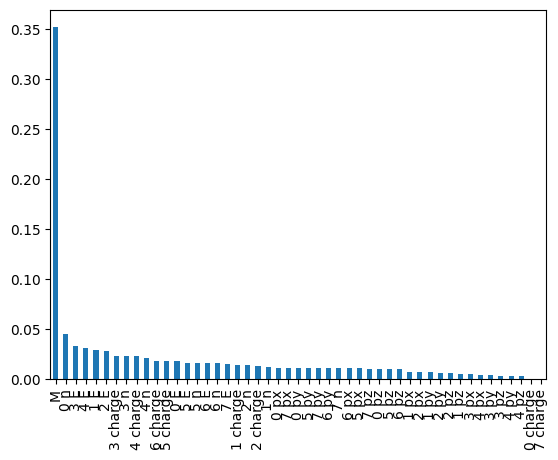

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=feat_name).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();